## 交通流模型   

传统跟驰模型校正 

参考：
https://github.com/iyangli/Car-following-Model-Calibration/blob/main/Code/IDM%2CFVD.py

数据集：exiD

### 导入

In [1]:
import numpy as np
from sko.GA import GA, GA_TSP
import pandas as pd
import  pandas  as pd
from  pandas import  DataFrame as df
import numpy as np
# import skfuzzy as fuzz
# from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import math
import os
import sys

In [3]:
os.path.dirname(os.path.abspath(__file__))

NameError: name '__file__' is not defined

### 跟驰数据
数据切片 & 提取

In [31]:
# 读取数据
total_data=pd.read_csv("D:/Desktop/开题/code/exiD/data/00_tracks.csv")
data=df(total_data[['trackId', 'frame', 'xCenter', 'yCenter', 'lonVelocity', 'latVelocity', 'lonAcceleration', 'lonLaneletPos', 'leadId', 'leadDHW']])
del total_data
# data.head()

#拼接跟驰车组
data = pd.merge(data, data, left_on=['leadId', 'frame'], right_on=['trackId', 'frame'], how='left', suffixes=('', '_lead'))
#删除NA行
data=data.dropna(axis=0, how='any')
del data['trackId_lead']
del data['leadId_lead']
del data['leadDHW_lead']
data.head()


d:\ProgramData\Anaconda3\envs\python3\envs\py37\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,trackId,frame,xCenter,yCenter,lonVelocity,latVelocity,lonAcceleration,lonLaneletPos,leadId,leadDHW,xCenter_lead,yCenter_lead,lonVelocity_lead,latVelocity_lead,lonAcceleration_lead,lonLaneletPos_lead
205,3,0,403.8263,-230.0390,31.2677,-0.0,0.4521,5.72,0,33.64,380.7679,-200.3428,31.9832,-0.0,0.3884,43.32
206,3,1,403.0660,-229.0478,31.2873,-0.0,0.4519,6.97,0,33.67,379.9906,-199.3281,32.0047,-0.0,0.3846,44.60
207,3,2,402.3050,-228.0557,31.3076,-0.0,0.4510,8.22,0,33.70,379.2125,-198.3121,32.0264,-0.0,0.3782,45.88
208,3,3,401.5434,-227.0626,31.3283,-0.0,0.4491,9.47,0,33.73,378.4335,-197.2947,32.0478,-0.0,0.3694,47.16
209,3,4,400.7812,-226.0685,31.3493,-0.0,0.4460,10.73,0,33.76,377.6538,-196.2763,32.0687,-0.0,0.3581,48.44


In [52]:
#换道数据清洗
data['lonLaneletPos'] = data['lonLaneletPos'].apply(lambda x: x.split(';')[0])
data['lonLaneletPos_lead'] = data['lonLaneletPos_lead'].apply(lambda x: x.split(';')[0])
data['lonLaneletPos'] = data['lonLaneletPos'].astype('float64')
data['lonLaneletPos_lead'] = data['lonLaneletPos_lead'].astype('float64')

In [53]:
data.head()

,trackId,frame,xCenter,yCenter,lonVelocity,latVelocity,lonAcceleration,lonLaneletPos,leadId,leadDHW,xCenter_lead,yCenter_lead,lonVelocity_lead,latVelocity_lead,lonAcceleration_lead,lonLaneletPos_lead
205,3,0,403.8263,-230.0390,31.2677,-0.0,0.4521,5.72,0,33.64,380.7679,-200.3428,31.9832,-0.0,0.3884,43.32
206,3,1,403.0660,-229.0478,31.2873,-0.0,0.4519,6.97,0,33.67,379.9906,-199.3281,32.0047,-0.0,0.3846,44.60
207,3,2,402.3050,-228.0557,31.3076,-0.0,0.4510,8.22,0,33.70,379.2125,-198.3121,32.0264,-0.0,0.3782,45.88
208,3,3,401.5434,-227.0626,31.3283,-0.0,0.4491,9.47,0,33.73,378.4335,-197.2947,32.0478,-0.0,0.3694,47.16
209,3,4,400.7812,-226.0685,31.3493,-0.0,0.4460,10.73,0,33.76,377.6538,-196.2763,32.0687,-0.0,0.3581,48.44


### 地图

In [ ]:
# total_data=pd.read_csv("D:/Desktop/开题/code/exiD/data/00_tracks.csv")
# data=df(total_data[['laneletId', 'laneWidth', 'latLaneCenterOffset', 'laneletLength','odrRoadId', 'odrLaneId']])
# del total_data
# data.head()

#### osm
osm文件中提取 way 中的 node

In [14]:
!pip install osmnx

osmnx

In [1]:
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --trusted-host pypi.tuna.tsinghua.edu.cn --user pyzmq==19.0.2

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 1.0/1.0 MB 21.9 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-client 7.4.8 requires pyzmq>=23.0, but you have pyzmq 19.0.2 which is incompatible.


In [2]:
import osmnx as ox
import geopandas as gpd

In [3]:
G = ox.graph_from_xml(r'D:\Desktop\开题\code\exiD\data\0_cologne_butzweiler.osm')

: 

: 

osm2gmns

In [10]:
import osm2gmns as og
net = og.getNetFromFile('D:\\Desktop\\开题\\code\\exiD\\data\\0_cologne_butzweiler.osm')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



arguments used for network parsing:
  filename: D:\Desktop\开题\code\exiD\data\0_cologne_butzweiler.osm
  network_types: ('auto',)
  link_types: all
  POI: False
  POI_sampling_ratio: 1.0
  strict_mode: True
  offset: no
  min_nodes: 1
  combine: False
  bbox: None
  default_lanes: False
  default_speed: False
  default_capacity: False
  start_node_id: 0
  start_link_id: 0

Building Network from OSM file
  reading osm file
Traceback (most recent call last):
  File "d:\ProgramData\Anaconda3\envs\python3\envs\py37\lib\site-packages\osm2gmns\io\read_from_osm.py", line 229, in _getBounds
    f = osmium.io.Reader(filename)
RuntimeError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\ProgramData\Anaconda3\envs\python3\envs\py37\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\zxh\AppData\Local\Temp\ipykernel_145000\3778804923.py",

TypeError: object of type 'NoneType' has no len()

In [ ]:
o

### 拟合函数
使用遗传算法
- GA
- IDM
- FVD

#### 损失函数

In [54]:
def get_mse(records_real, records_predict):
    """
    均方误差 估计值与真值 偏差
    """
    if len(records_real) == len(records_predict):
        return sum([(x - y) ** 2 for x, y in zip(records_real, records_predict)]) / len(records_real)
    else:
        return None


def get_rmse(records_real, records_predict):
    """
    均方根误差：是均方误差的算术平方根
    """
    mse = get_mse(records_real, records_predict)
    if mse:
        return math.sqrt(mse)
    else:
        return None

#### IDM


In [21]:
# 遗传算法
def function_idm(p):

    x1,x2,x3,x4,x5,x6,x7 = p
    Length_of_Car=x1
    Maximum_Acc = x2  # 最大加速度
    Comfortable_Dec =x3  # 舒适减速度
    Desire_Spe=x4  # 期望速度
    Desire_Spa_Tim =x5  # 期望车头时距
    Minimum_Spa = x6  # 最短车头间距
    Para_Beta = x7  # 加速度系数

    simulated_spe = []
    cur_sim_acc = []
    simulate_headway = []
    cur_sim_hea = space_headway[0]
    cur_sim_spe = follower_speed[0]

    for i in range(len(group)):

        cur_forhead_spe = forhead_speed[i]
        cur_head_space = space_headway[i]
        cur_follower_speed = follower_speed[i]

        try:
            cur_des_spa = Minimum_Spa + cur_follower_speed * Desire_Spa_Tim + 0 * math.sqrt(cur_follower_speed / Desire_Spe) + \
                            (cur_follower_speed * (cur_follower_speed - cur_forhead_spe)) / (
                                    2 * math.sqrt(Maximum_Acc * Comfortable_Dec))
        except:
            cur_des_spa=5

        cur_follow_1_acc = Maximum_Acc * (1 - math.pow((cur_follower_speed / Desire_Spe), Para_Beta) -
                                    math.pow(cur_des_spa / (cur_head_space - Length_of_Car),
                                            2))

        cur_sim_spe = cur_sim_spe + cur_follow_1_acc
        cur_sim_hea = cur_sim_hea + cur_sim_spe

        simulated_spe.append(cur_sim_spe)
        simulate_headway.append(cur_sim_hea)
        cur_sim_acc.append(cur_follow_1_acc)

    abs_sum_1 = 0
    for i in range(len(cur_sim_acc)):
        abs_sum_1 += abs(cur_sim_acc[i])

    abs_sum_2 = 0
    for i in range(len(cur_sim_acc)):
        abs_sum_2 += (cur_sim_acc[i] - follower_acc[i]) ** 2 / (abs(follower_acc[i]))

    youhua = abs_sum_2 / abs_sum_1

    return get_rmse(follower_acc,cur_sim_acc)

In [22]:
def draw_picture_idm(p):

    x1,x2,x3,x4,x5,x6,x7 = p
    Length_of_Car=x1
    Maximum_Acc = x2  # 最大加速度
    Comfortable_Dec =x3  # 舒适减速度
    Desire_Spe=x4  # 期望速度
    Desire_Spa_Tim =x5  # 期望车头时距
    Minimum_Spa = x6  # 最短车头间距
    Para_Beta = x7  # 加速度系数

    simulated_spe = []
    cur_sim_acc = []
    simulate_position = []
    cur_sim_spe = follower_speed[0]
    cur_simu_position = follower_position[0]

    for i in range(len(group)):

        cur_forhead_spe = forhead_speed[i]
        cur_head_space = space_headway[i]
        cur_follower_speed = follower_speed[i]

        cur_des_spa = Minimum_Spa + cur_follower_speed * Desire_Spa_Tim + 0 * math.sqrt(cur_follower_speed / Desire_Spe) + \
                        (cur_follower_speed * (cur_follower_speed - cur_forhead_spe)) / (
                                2 * math.sqrt(Maximum_Acc * Comfortable_Dec))

        cur_follow_1_acc = Maximum_Acc * (1 - math.pow((cur_follower_speed / Desire_Spe), Para_Beta) -
                                    math.pow(cur_des_spa / (cur_head_space - Length_of_Car),
                                            2))

        simulated_spe.append(cur_sim_spe)
        simulate_position.append(cur_simu_position)

        cur_sim_spe = cur_sim_spe + cur_follow_1_acc*0.1
        cur_simu_position = cur_simu_position + cur_sim_spe*0.1

        cur_sim_acc.append(cur_follow_1_acc)


    return simulated_spe,cur_sim_acc,simulate_position

#### FVD

In [23]:
 # FVD遗传算法
# 遗传算法
def function_fvd(p):

    x1,x2,x3,x4,x5,x6,x7 = p
    # 期望速度
    Desire_Spe = x1
        # 常敏感性系数
    Constant_Sensitivity_Coe = x2
    # 相对速度差敏感性系数
    Rel_Spe_Sen_Coe = x3
    # beta，b系数
    Para_Beta=x4
    Para_b =x5
    # 自由流与跟驰策略的间距阈值
    Max_Fol_Dis = x6
    # 有效的车长
    Eff_veh_len = x7

    simulated_spe = []
    cur_sim_acc = []
    simulate_headway = []
    cur_sim_hea = space_headway[0]
    cur_sim_spe = follower_speed[0]

    for i in range(len(group)):

        cur_forhead_spe = forhead_speed[i]
        cur_head_space = space_headway[i]
        cur_follower_speed = follower_speed[i]

        # 后车参数的更新
        if cur_head_space <= Max_Fol_Dis:
            cur_Rel_Spe_Sen_Coe = Rel_Spe_Sen_Coe
        else:
            cur_Rel_Spe_Sen_Coe = 0

        cur_bef_des_spe = (0.5 * Desire_Spe) * (
                math.tanh(((cur_head_space - Eff_veh_len) / Para_b - Para_Beta))
                - math.tanh(-Para_Beta))
        cur_follow_1_acc = Constant_Sensitivity_Coe * (cur_bef_des_spe - cur_follower_speed) + cur_Rel_Spe_Sen_Coe * (cur_forhead_spe - cur_follower_speed)



        cur_sim_spe = cur_sim_spe + cur_follow_1_acc
        cur_sim_hea = cur_sim_hea + cur_sim_spe

        simulated_spe.append(cur_sim_spe)
        simulate_headway.append(cur_sim_hea)
        cur_sim_acc.append(cur_follow_1_acc)

    return get_rmse(follower_acc,cur_sim_acc)

In [24]:
def draw_picture_fvd(p):

    x1,x2,x3,x4,x5,x6,x7 = p
    # 期望速度
    Desire_Spe = x1
    # 常敏感性系数
    Constant_Sensitivity_Coe = x2
    # 相对速度差敏感性系数
    Rel_Spe_Sen_Coe = x3
    # beta，b系数
    Para_Beta=x4
    Para_b =x5
    # 自由流与跟驰策略的间距阈值
    Max_Fol_Dis = x6
    # 有效的车长
    Eff_veh_len = x7

    simulated_spe = []
    cur_sim_acc = []
    simulate_position = []
    cur_sim_spe = follower_speed[0]
    cur_simu_position=follower_position[0]

    for i in range(len(group)):

        cur_forhead_spe = forhead_speed[i]
        cur_head_space = space_headway[i]
        cur_follower_speed = follower_speed[i]

        # 后车参数的更新
        if cur_head_space <= Max_Fol_Dis:
            cur_Rel_Spe_Sen_Coe = Rel_Spe_Sen_Coe
        else:
            cur_Rel_Spe_Sen_Coe = 0

        cur_bef_des_spe = (0.5 * Desire_Spe) * (
                math.tanh(((cur_head_space - Eff_veh_len) / Para_b - Para_Beta))
                - math.tanh(-Para_Beta))
        cur_follow_1_acc = Constant_Sensitivity_Coe * (cur_bef_des_spe - cur_follower_speed) + cur_Rel_Spe_Sen_Coe * (cur_forhead_spe - cur_follower_speed)



        simulated_spe.append(cur_sim_spe)
        simulate_position.append(cur_simu_position)

        cur_sim_spe = cur_sim_spe + cur_follow_1_acc*0.1
        cur_simu_position = cur_simu_position + cur_sim_spe*0.1

        cur_sim_acc.append(cur_follow_1_acc)

    return simulated_spe,cur_sim_acc,simulate_position

### 训练

In [55]:
simulate_data=pd.DataFrame()
final_parameter_idm=pd.DataFrame()
final_loss_idm=pd.DataFrame()
final_parameter_fvd=pd.DataFrame()
final_loss_fvd=pd.DataFrame()

In [57]:
# ga的边界

lb_x_idm = [4,3,4,10,0.1,0.1,0.1]
ub_x_idm = [6,8,10,30,10,10,10]

lb_x_fvd = [10,0.1,0.1,0.1,0.1,5,4]
ub_x_fvd = [30,10,10,10,10,50,6]


In [40]:
data.head()

,trackId,frame,xCenter,yCenter,lonVelocity,latVelocity,lonAcceleration,lonLaneletPos,leadId,leadDHW,xCenter_lead,yCenter_lead,lonVelocity_lead,latVelocity_lead,lonAcceleration_lead,lonLaneletPos_lead
205,3,0,403.8263,-230.0390,31.2677,-0.0,0.4521,5.72,0,33.64,380.7679,-200.3428,31.9832,-0.0,0.3884,43.32
206,3,1,403.0660,-229.0478,31.2873,-0.0,0.4519,6.97,0,33.67,379.9906,-199.3281,32.0047,-0.0,0.3846,44.60
207,3,2,402.3050,-228.0557,31.3076,-0.0,0.4510,8.22,0,33.70,379.2125,-198.3121,32.0264,-0.0,0.3782,45.88
208,3,3,401.5434,-227.0626,31.3283,-0.0,0.4491,9.47,0,33.73,378.4335,-197.2947,32.0478,-0.0,0.3694,47.16
209,3,4,400.7812,-226.0685,31.3493,-0.0,0.4460,10.73,0,33.76,377.6538,-196.2763,32.0687,-0.0,0.3581,48.44


In [58]:

# 开始遍历数据中的每一段跟驰数据
for id,group in data.groupby("trackId"):
    forehead_position = group["lonLaneletPos_lead"].values
    follower_position = group["lonLaneletPos"].values
    forhead_speed = group["lonVelocity_lead"].values
    space_headway = group["leadDHW"].values #
    follower_speed = group["lonVelocity"].values
    follower_acc = group["lonAcceleration"].values


    # try:
    # IDM遗传算法
    def function_idm(p):

        x1,x2,x3,x4,x5,x6,x7 = p
        Length_of_Car=x1
        Maximum_Acc = x2  # 最大加速度
        Comfortable_Dec =x3  # 舒适减速度
        Desire_Spe=x4  # 期望速度
        Desire_Spa_Tim =x5  # 期望车头时距
        Minimum_Spa = x6  # 最短车头间距
        Para_Beta = x7  # 加速度系数

        simulated_spe = []
        cur_sim_acc = []
        simulate_headway = []
        cur_sim_hea = space_headway[0]
        cur_sim_spe = follower_speed[0]

        for i in range(len(group)):

            cur_forhead_spe = forhead_speed[i]
            cur_head_space = space_headway[i]
            cur_follower_speed = follower_speed[i]

            try:
                cur_des_spa = Minimum_Spa + cur_follower_speed * Desire_Spa_Tim + 0 * math.sqrt(cur_follower_speed / Desire_Spe) + \
                                (cur_follower_speed * (cur_follower_speed - cur_forhead_spe)) / (
                                        2 * math.sqrt(Maximum_Acc * Comfortable_Dec))
            except:
                cur_des_spa=5

            cur_follow_1_acc = Maximum_Acc * (1 - math.pow((cur_follower_speed / Desire_Spe), Para_Beta) -
                                        math.pow(cur_des_spa / (cur_head_space - Length_of_Car),
                                                2))

            cur_sim_spe = cur_sim_spe + cur_follow_1_acc
            cur_sim_hea = cur_sim_hea + cur_sim_spe

            simulated_spe.append(cur_sim_spe)
            simulate_headway.append(cur_sim_hea)
            cur_sim_acc.append(cur_follow_1_acc)

        abs_sum_1 = 0
        for i in range(len(cur_sim_acc)):
            abs_sum_1 += abs(cur_sim_acc[i])

        abs_sum_2 = 0
        for i in range(len(cur_sim_acc)):
            abs_sum_2 += (cur_sim_acc[i] - follower_acc[i]) ** 2 / (abs(follower_acc[i]))

        youhua = abs_sum_2 / abs_sum_1

        return get_rmse(follower_acc,cur_sim_acc)


    ga_idm= GA(func=function_idm, n_dim=7, max_iter=20, size_pop=20, lb=lb_x_idm, ub=ub_x_idm)

    #得到最优的x和y
    best_x_idm, best_y_idm = ga_idm.run()
    cur_id_idm="%s,idm"%id

    #IDM模型拟合
    def draw_picture_idm(p):

        x1,x2,x3,x4,x5,x6,x7 = p
        Length_of_Car=x1
        Maximum_Acc = x2  # 最大加速度
        Comfortable_Dec =x3  # 舒适减速度
        Desire_Spe=x4  # 期望速度
        Desire_Spa_Tim =x5  # 期望车头时距
        Minimum_Spa = x6  # 最短车头间距
        Para_Beta = x7  # 加速度系数

        simulated_spe = []
        cur_sim_acc = []
        simulate_position = []
        cur_sim_spe = follower_speed[0]
        cur_simu_position = follower_position[0]

        for i in range(len(group)):

            cur_forhead_spe = forhead_speed[i]
            cur_head_space = space_headway[i]
            cur_follower_speed = follower_speed[i]

            cur_des_spa = Minimum_Spa + cur_follower_speed * Desire_Spa_Tim + 0 * math.sqrt(cur_follower_speed / Desire_Spe) + \
                            (cur_follower_speed * (cur_follower_speed - cur_forhead_spe)) / (
                                    2 * math.sqrt(Maximum_Acc * Comfortable_Dec))

            cur_follow_1_acc = Maximum_Acc * (1 - math.pow((cur_follower_speed / Desire_Spe), Para_Beta) -
                                        math.pow(cur_des_spa / (cur_head_space - Length_of_Car),
                                                2))

            simulated_spe.append(cur_sim_spe)
            simulate_position.append(cur_simu_position)

            cur_sim_spe = cur_sim_spe + cur_follow_1_acc*0.1
            cur_simu_position = cur_simu_position + cur_sim_spe*0.1

            cur_sim_acc.append(cur_follow_1_acc)

        return simulated_spe,cur_sim_acc,simulate_position
    
    simulate_spe_idm,simulated_acc_idm, simulate_postion_idm= draw_picture_idm(best_x_idm)

    #FVD遗传算法
    def function_fvd(p):

        x1,x2,x3,x4,x5,x6,x7 = p
        # 期望速度
        Desire_Spe = x1
        # 常敏感性系数
        Constant_Sensitivity_Coe = x2
        # 相对速度差敏感性系数
        Rel_Spe_Sen_Coe = x3
        # beta，b系数
        Para_Beta=x4
        Para_b =x5
        # 自由流与跟驰策略的间距阈值
        Max_Fol_Dis = x6
        # 有效的车长
        Eff_veh_len = x7

        simulated_spe = []
        cur_sim_acc = []
        simulate_headway = []
        cur_sim_hea = space_headway[0]
        cur_sim_spe = follower_speed[0]

        for i in range(len(group)):

            cur_forhead_spe = forhead_speed[i]
            cur_head_space = space_headway[i]
            cur_follower_speed = follower_speed[i]

            # 后车参数的更新
            if cur_head_space <= Max_Fol_Dis:
                cur_Rel_Spe_Sen_Coe = Rel_Spe_Sen_Coe
            else:
                cur_Rel_Spe_Sen_Coe = 0

            cur_bef_des_spe = (0.5 * Desire_Spe) * (
                    math.tanh(((cur_head_space - Eff_veh_len) / Para_b - Para_Beta))
                    - math.tanh(-Para_Beta))
            cur_follow_1_acc = Constant_Sensitivity_Coe * (cur_bef_des_spe - cur_follower_speed) + cur_Rel_Spe_Sen_Coe * (cur_forhead_spe - cur_follower_speed)



            cur_sim_spe = cur_sim_spe + cur_follow_1_acc
            cur_sim_hea = cur_sim_hea + cur_sim_spe

            simulated_spe.append(cur_sim_spe)
            simulate_headway.append(cur_sim_hea)
            cur_sim_acc.append(cur_follow_1_acc)

        return get_rmse(follower_acc,cur_sim_acc)

    ga_fvd= GA(func=function_fvd, n_dim=7, max_iter=20, size_pop=20, lb=lb_x_fvd, ub=ub_x_fvd)

    #得到最优的x和y
    best_x_fvd, best_y_fvd = ga_fvd.run()
    cur_id_fvd="%s,fvd"%id

    def draw_picture_fvd(p):

        x1,x2,x3,x4,x5,x6,x7 = p
        # 期望速度
        Desire_Spe = x1
        # 常敏感性系数
        Constant_Sensitivity_Coe = x2
        # 相对速度差敏感性系数
        Rel_Spe_Sen_Coe = x3
        # beta，b系数
        Para_Beta=x4
        Para_b =x5
        # 自由流与跟驰策略的间距阈值
        Max_Fol_Dis = x6
        # 有效的车长
        Eff_veh_len = x7

        simulated_spe = []
        cur_sim_acc = []
        simulate_position = []
        cur_sim_spe = follower_speed[0]
        cur_simu_position=follower_position[0]

        for i in range(len(group)):

            cur_forhead_spe = forhead_speed[i]
            cur_head_space = space_headway[i]
            cur_follower_speed = follower_speed[i]

            # 后车参数的更新
            if cur_head_space <= Max_Fol_Dis:
                cur_Rel_Spe_Sen_Coe = Rel_Spe_Sen_Coe
            else:
                cur_Rel_Spe_Sen_Coe = 0

            cur_bef_des_spe = (0.5 * Desire_Spe) * (
                    math.tanh(((cur_head_space - Eff_veh_len) / Para_b - Para_Beta))
                    - math.tanh(-Para_Beta))
            cur_follow_1_acc = Constant_Sensitivity_Coe * (cur_bef_des_spe - cur_follower_speed) + cur_Rel_Spe_Sen_Coe * (cur_forhead_spe - cur_follower_speed)

            simulated_spe.append(cur_sim_spe)
            simulate_position.append(cur_simu_position)

            cur_sim_spe = cur_sim_spe + cur_follow_1_acc*0.1
            cur_simu_position = cur_simu_position + cur_sim_spe*0.1

            cur_sim_acc.append(cur_follow_1_acc)

        return simulated_spe,cur_sim_acc,simulate_position

    simulate_spe_fvd,simulated_acc_fvd, simulate_postion_fvd= draw_picture_fvd(best_x_fvd)

    # ________________________________________________________________________________输出

    cur_id_sim_acc_fvd = "%s,simulate_acc" % cur_id_fvd
    cur_id_sim_spe_fvd = "%s,simulate_spe" % cur_id_fvd
    cur_id_sim_follower_position_fvd = "%s,sim_follower_poi" % cur_id_fvd

    cur_id_sim_acc_idm="%s,simulate_acc"%cur_id_idm
    cur_id_tru_acc_idm="%s,true_acc"%cur_id_idm
    cur_id_tru_spe_idm="%s,true_spe"%cur_id_idm
    cur_id_sim_spe_idm="%s,simulate_spe"%cur_id_idm
    cur_id_tru_follower_position_idm="%s,true_follower_poi"%cur_id_idm
    cur_id_sim_follower_position_idm="%s,sim_follower_poi"%cur_id_idm
    cur_id_tru_forehead_position_idm="%s,leader_poi"%cur_id_idm

    # 导出
    cur_pd_id=pd.DataFrame()
    # 加速度
    cur_pd_id[cur_id_tru_acc_idm]=follower_acc
    cur_pd_id[cur_id_sim_acc_idm]=simulated_acc_idm
    cur_pd_id[cur_id_sim_acc_fvd]=simulated_acc_fvd

    # 速度
    cur_pd_id[cur_id_tru_spe_idm]=follower_speed
    cur_pd_id[cur_id_sim_spe_idm]=simulate_spe_idm
    cur_pd_id[cur_id_sim_spe_fvd]=simulate_spe_fvd

    cur_pd_id[cur_id_tru_forehead_position_idm]=forehead_position
    cur_pd_id[cur_id_tru_follower_position_idm]=follower_position
    cur_pd_id[cur_id_sim_follower_position_idm]=simulate_postion_idm
    cur_pd_id[cur_id_sim_follower_position_fvd]=simulate_postion_fvd


    final_parameter_idm[cur_id_idm]=best_x_idm
    final_loss_idm[cur_id_idm]=best_y_idm
    final_parameter_fvd[cur_id_fvd]=best_x_fvd
    final_loss_fvd[cur_id_fvd]=best_y_fvd

    simulate_data = pd.concat([cur_pd_id,simulate_data],axis=1)

    # except:
    #     ""


d:\ProgramData\Anaconda3\envs\python3\envs\py37\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars
d:\ProgramData\Anaconda3\envs\python3\envs\py37\lib\site-packages\ipykernel_launcher.py:259: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
d:\ProgramData\Anaconda3\envs\python3\envs\py37\lib\site-packages\ipykernel_launcher.py:260: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
d:\ProgramData\Anaconda3\envs\python3\envs\py37\lib\site-packages\ipykernel_launcher.py:261: PerformanceW

#### 参数

筛选平滑最小的loss

##### IDM
$$
\dot v_a (s_e,v_e,\triangle v_e) = a[1-(\frac{v_e}{v_0})^{\delta} -(\frac{s^*(v_e,\triangle v_e)}{s_e})^2 ] \\
s^*(v_e,\triangle v_e) = s_0 + \max (v_e T+\frac{v_e \triangle v_e}{2\sqrt{ab}}, 0)
$$

In [66]:
loss_idm_list = final_loss_idm.values
parameter_idm_list = final_parameter_idm.values
# parameter_idm_list
which_min_idm = np.argmin(loss_idm_list)
print('IDM模型最优参数为：', parameter_idm_list[:,which_min_idm])

array([[4.57058741, 4.31251026, 4.47336461, ..., 4.23175163, 4.54167254,
        4.03990382],
       [3.93529338, 3.02094813, 4.37059691, ..., 3.1677464 , 3.39729365,
        4.35630245],
       [4.40665579, 9.161168  , 8.38189123, ..., 8.60097049, 7.70819559,
        8.91431598],
       ...,
       [1.84847538, 1.44500342, 0.22766068, ..., 0.52006503, 2.8915914 ,
        0.61494451],
       [0.19121092, 1.66594408, 6.4352249 , ..., 1.27593413, 0.61728671,
        1.03440492],
       [0.10882732, 0.59309864, 0.35411242, ..., 6.66424812, 0.14842806,
        0.60422951]])

In [73]:
min_loss_iter_idm = [i for i in range(len(loss_idm_list[0])) if loss_idm_list[0][i] < 0.1]
print(len(min_loss_iter_idm))
# Length_of_Car=x1
# Maximum_Acc = x2  # 最大加速度
# Comfortable_Dec =x3  # 舒适减速度
# Desire_Spe=x4  # 期望速度
# Desire_Spa_Tim =x5  # 期望车头时距
# Minimum_Spa = x6  # 最短车头间距
# Para_Beta = x7  # 加速度系数
Length_of_Car_list = parameter_idm_list[0][min_loss_iter_idm]
Maximum_Acc_list = parameter_idm_list[1][min_loss_iter_idm]
Comfortable_Dec_list = parameter_idm_list[2][min_loss_iter_idm]
Desire_Spe_list = parameter_idm_list[3][min_loss_iter_idm]
Desire_Spa_Tim_list = parameter_idm_list[4][min_loss_iter_idm]
Minimum_Spa_list = parameter_idm_list[5][min_loss_iter_idm]
Para_Beta_list = parameter_idm_list[6][min_loss_iter_idm]


57


In [75]:
#a
print(Maximum_Acc_list)

[3.23086116 4.2279162  3.42745263 3.78000576 5.40748856 3.15719295
 3.12201905 3.19210644 3.87140003 4.16458179 3.63720883 6.82712094
 4.55290256 3.49194381 3.33004985 5.58765999 3.28710336 4.40075172
 3.21861561 4.7889675  3.23347102 7.2949026  3.23146525 4.20399663
 3.29160537 3.07168181 6.52017125 6.53870412 3.49150214 4.25524851
 4.98198642 3.80816851 5.36559283 5.17086378 4.02625379 3.6547247
 3.39326951 3.96018033 3.13460174 3.48728944 3.42837553 4.62056061
 3.06696239 3.28032296 3.04455634 7.41272161 4.48173357 3.48094005
 4.36932174 3.16095072 6.49747223 3.07880941 5.76951988 3.64346754
 4.68267767 6.24452308 3.2738867 ]


In [76]:
#b
print(Comfortable_Dec_list)

[9.07941105 9.83875605 4.12823785 5.55881094 5.07820173 9.82240969
 5.14220675 4.41872368 9.29149546 9.70948359 6.43358911 7.79238057
 4.80889319 7.2211632  6.83496909 5.5201292  8.73306731 7.66024816
 9.13200237 7.90326953 4.01301014 9.44467937 4.5845964  7.23104115
 8.42004011 7.98126209 4.22940666 7.77904588 9.80183071 4.64536552
 9.95083296 8.79529805 5.18346234 6.83581944 8.14150414 6.34206346
 6.39052374 8.00486758 8.9723867  5.10585378 9.75445887 5.73799869
 8.95860855 8.78628529 4.04791132 5.14333524 9.11871301 4.28603524
 4.91531913 4.51428122 4.93122212 4.46045894 4.52634079 5.37919887
 6.89427702 4.7076735  9.18008982]


以上结果可知，模型拟合较为不稳定、不收敛，损失非凸，难以找到最优解

#### FVD

$$
\frac{dv_{n+1}}{dt}=k[V(s)-v_{n+1}(t)] + \lambda \triangle v
$$

In [77]:
loss_fvd_list = final_loss_fvd.values
parameter_fvd_list = final_parameter_fvd.values
# parameter_idm_list
which_min_fvd = np.argmin(loss_fvd_list)
print('FVD模型最优参数为：', parameter_fvd_list[:,which_min_fvd])

IDM模型最优参数为： [27.38265759  1.27786614  3.12147688  7.17909327  2.28911132 22.19039713
  5.14566657]


In [78]:
min_loss_iter_fvd = [i for i in range(len(loss_fvd_list[0])) if loss_fvd_list[0][i] < 0.1]
print(len(min_loss_iter_fvd))
    # # 期望速度
    # Desire_Spe = x1
    #     # 常敏感性系数
    # Constant_Sensitivity_Coe = x2
    # # 相对速度差敏感性系数
    # Rel_Spe_Sen_Coe = x3
    # # beta，b系数
    # Para_Beta=x4
    # Para_b =x5
    # # 自由流与跟驰策略的间距阈值
    # Max_Fol_Dis = x6
    # # 有效的车长
    # Eff_veh_len = x7
Desire_Spe_list = parameter_fvd_list[0][min_loss_iter_fvd]
Constant_Sensitivity_Coe_list = parameter_fvd_list[1][min_loss_iter_fvd]
Max_Fol_Dis_list = parameter_fvd_list[5][min_loss_iter_fvd]

40


In [79]:
print(Desire_Spe_list)

[29.32796336 28.98559846 28.97150792 24.13216574 23.31633379 24.36935572
 29.00811046 25.47440095 27.38265759 25.66223322 21.58557978 24.78488302
 25.87814195 25.02616441 27.27827831 24.5565263  22.14295958 28.1507565
 26.94358899 26.34820765 29.56686839 26.18586025 21.10947136 24.68950769
 29.88835461 22.63433275 27.32982582 26.64564377 27.66063727 24.55670899
 23.35599159 27.56748154 27.32063687 28.44192624 27.04394623 22.56821361
 28.33750516 29.46728751 28.05289201 24.88627007]


In [80]:
print(Desire_Spe_list)

[29.32796336 28.98559846 28.97150792 24.13216574 23.31633379 24.36935572
 29.00811046 25.47440095 27.38265759 25.66223322 21.58557978 24.78488302
 25.87814195 25.02616441 27.27827831 24.5565263  22.14295958 28.1507565
 26.94358899 26.34820765 29.56686839 26.18586025 21.10947136 24.68950769
 29.88835461 22.63433275 27.32982582 26.64564377 27.66063727 24.55670899
 23.35599159 27.56748154 27.32063687 28.44192624 27.04394623 22.56821361
 28.33750516 29.46728751 28.05289201 24.88627007]


In [81]:
print(Max_Fol_Dis_list)

[26.5268848  36.75662021 32.60126689 28.20270209 15.61198657 12.77834807
 12.90140137 37.93372155 22.19039713 25.16555744 23.58437343 34.4756741
 34.56617703 29.16354748 19.3927802  34.41944594 32.3211426  33.37756255
 35.75931546  9.08555042 28.46956043 14.10277025 38.82855107 13.21285545
 13.37234053 14.59076926  7.02090159 30.52233907 47.42736576 35.08692849
 48.92564948 11.45651138 48.40187139 19.30713316  5.87113338 22.48975656
 22.37698174 32.39989938 27.47541416 18.29725188]


#### 分布检验

In [93]:
simulate_data.shape

(486, 13460)

In [100]:
simulate_data[0:10]['3,idm,true_acc']

0    0.4521
1    0.4519
2    0.4510
3    0.4491
4    0.4460
5    0.4417
6    0.4361
7    0.4291
8    0.4206
9    0.4106
Name: 3,idm,true_acc, dtype: float64

分布提取：前10s

In [102]:
# col_list = [i for i in range(3,1400)]
spd_true, spd_idm, spd_fvd = [], [], []
acc_true, acc_idm, acc_fvd = [], [], []

for i in range(3,1400):
    col_true_spe = '%s,idm,true_spe' % i
    col_idm_spe = '%s,idm,simulate_spe' % i
    col_fvd_spe = '%s,fvd,simulate_spe' % i
    col_true_acc = '%s,idm,true_acc' % i
    col_idm_acc = '%s,idm,simulate_acc' % i
    col_fvd_acc = '%s,fvd,simulate_acc' % i

    try: 
        spd_true.extend(simulate_data[0:10][col_true_spe])
        spd_idm.extend(simulate_data[0:10][col_idm_spe])
        spd_fvd.extend(simulate_data[0:10][col_fvd_spe])
        acc_true.extend(simulate_data[0:10][col_true_acc])
        acc_idm.extend(simulate_data[0:10][col_idm_acc])
        acc_fvd.extend(simulate_data[0:10][col_fvd_acc])
    except:
        continue

print(len(spd_true), len(acc_true))

13430 13430


In [109]:
print(len(spd_idm), len(spd_fvd))

13430 13430


分布一致性检验：
- 速度
- 加速度

In [120]:
pd.Series(spd_idm).describe()

count     13417.000000
mean       -110.144522
std        6782.446633
min     -384808.619902
25%          22.884100
50%          25.238451
75%          27.983738
max          41.112500
dtype: float64

In [123]:
spd_idm_scale = [v for v in spd_idm if v > 0]
print(len(spd_idm_scale))

13200


In [130]:
pd.Series(acc_idm).describe()

count    1.341700e+04
mean    -2.957652e+02
std      2.027504e+04
min     -1.993383e+06
25%     -1.388939e+00
50%     -2.193071e-01
75%      2.658060e-01
max      3.665796e+00
dtype: float64

In [132]:
pd.Series(acc_fvd).describe()

count    13417.000000
mean        -0.140000
std          2.865412
min        -66.932937
25%         -0.543240
50%          0.112113
75%          0.615487
max         42.140038
dtype: float64

In [136]:
acc_idm_scale = [a for a in acc_idm if a > -20]
print(len(acc_idm_scale))
acc_fvd_scale = [a for a in acc_fvd if a > -20]
print(len(acc_fvd_scale))

12886
13403


Text(0.5, 1.0, 'Acc Distribution')

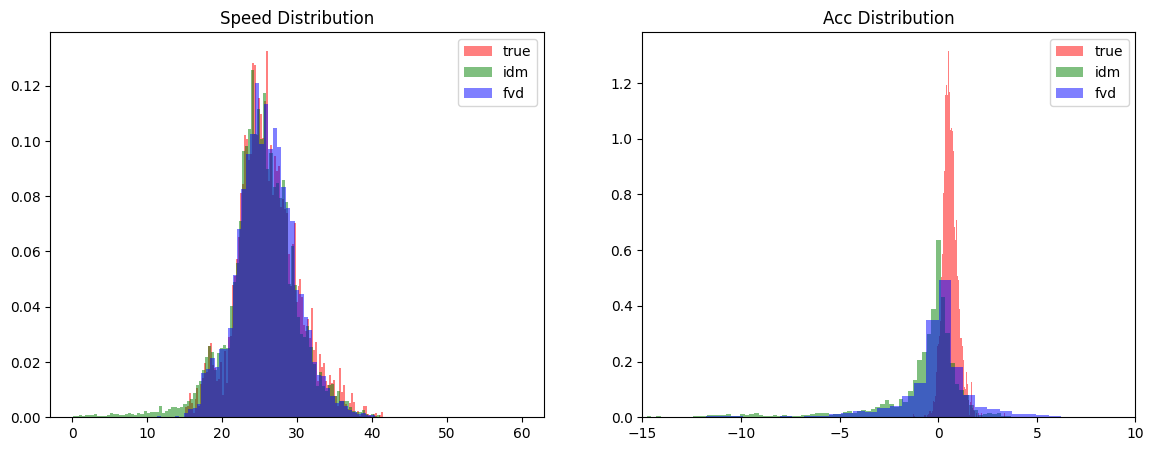

In [138]:
#密度估计
plt.figure(figsize=(14, 5))
# plt.figure(1)
ax1 = plt.subplot(121)
ax1.hist(spd_true, bins=100, alpha=0.5, label='true', color='red', density=True)
ax1.hist(spd_idm_scale, bins=100, alpha=0.5, label='idm', color='green', density=True)
ax1.hist(spd_fvd, bins=100, alpha=0.5, label='fvd', color='blue', density=True)
# ax1.xlim(10, 45)
ax1.legend()
ax1.set_title('Speed Distribution')
# ax1.show()

ax2 = plt.subplot(122)
ax2.hist(acc_true, bins=100, alpha=0.5, label='true', color='red', density=True)
ax2.hist(acc_idm_scale, bins=100, alpha=0.5, label='idm', color='green', density=True)
ax2.hist(acc_fvd_scale, bins=100, alpha=0.5, label='fvd', color='blue', density=True)
ax2.set_xlim(-15, 10)
ax2.legend()
ax2.set_title('Acc Distribution')

#### 存储

In [60]:
!pip install openpyxl

     -------------------------------------- 250.0/250.0 kB 2.2 MB/s eta 0:00:00


In [61]:

writer = pd.ExcelWriter('D:/Desktop/开题/code/exiD/data/00_tracks_sim.xlsx')
simulate_data.to_excel(writer,sheet_name="simulate_data")
final_parameter_idm.to_excel(writer,sheet_name="final_parameter_idm")
final_parameter_fvd.to_excel(writer,sheet_name="final_parameter_fvd")
final_loss_fvd.to_excel(writer,sheet_name="final_loss_fvd")
final_loss_idm.to_excel(writer,sheet_name="final_loss_idm")

writer.save()

#### SGD优化
TODO...

## 换道模型

## 一维机器学习

考虑纵向序列建模

### GRU

### Transformer

## 二维

### GNN
- VectorNet: polyline representation
- TrafficSim

### Transformer
Map encoder + motion encoder
- MTR
- Wayformer